

# Contents of the Repo , New York Taxi LFS  

In [253]:
# Getting Dendencies  

import pandas as pd
import csv
import numpy as np
from datetime import datetime
import datetime as dt
from datetime import timedelta  # it is a spanned based time . 
from datetime import datetime, date, time
from datetime import date

import matplotlib.pyplot as plt
import os, json, requests, pickle
from scipy.stats import skew
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare

#import scipy.stats as st
from sklearn.preprocessing import normalize, scale
from tabulate import tabulate #pretty print of tables. source: http://txt.arboreus.com/2013/03/13/pretty-print-tables-in-python.html
from shapely.geometry import Point,Polygon,MultiPoint
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
! pip install shapely
! pip install shapely[vectorized]
!pip install git-lfs
from scipy.stats import chisquare

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [254]:
# Firs Step . Download Dataset and Print out the size. 
if os.path.exists('Data_Sptember.csv'):# check if the Data is present and load it . 
    data= pd.read_csv('Data_Sptember.csv')
# else: # Download Data Jan if not available on desktop . 
#     url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-01.csv"
#     data= pd.read_url('url')
#     data= Data.to_csv(url.split('/')[-1]
                      
                
# print number rows and number of columns 
print("Number of rows:",data.shape[0]) 
print("Number of columns:",data.shape[1])


Number of rows: 1048575
Number of columns: 21


In [12]:
# data.head()

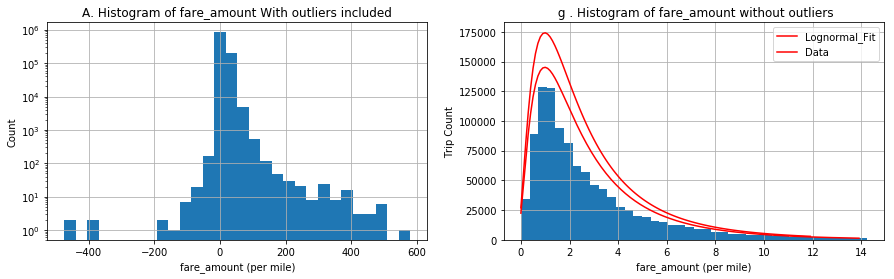

In [250]:
# define the figure with 2 subplots
fig,ax = plt.subplots(1,2,figsize = (15,4)) 

# Histogram of Number of Trip distance 

data.Fare_amount.hist(bins=30 , ax = ax[0])
ax[0].set_xlabel('fare_amount (per mile)')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('A. Histogram of fare_amount With outliers included')

# Create a vector to contain  Trip Distance

v = data.Trip_distance
# # Exclude any data point that is further than 4 standard deviations of median point 
# and plot hist with 40 bin

v[~((v-v.median()).abs()>4*  v.std())].hist(bins=40, ax= ax[1])
ax[1].set_xlabel('fare_amount (per mile)')
ax[1].set_ylabel('Trip Count')
ax[1].set_title(' g . Histogram of fare_amount without outliers')

# Apply a lognormal fit . use the mean of Trip Distancce as the scale parameter 
Scatter,loc,mean = lognorm.fit(data.Trip_distance.values,
                               scale = data.Trip_distance.mean(), 
                                loc = 0 )
pdf_fitted = lognorm.pdf(np.arange(0,14,.1), Scatter , loc, mean)
ax[1].plot(np.arange(0,14,.1), 500000 * pdf_fitted, 'r')
ax[1].legend (['Data', 'lognorm fit '])

# # # create a vector to contain Trip Distance
v = data.Trip_distance 
# # exclude any data point located further than 3 standard deviations of the median point and 
# # plot the histogram with 30 bins


# apply a lognormal fit. Use the mean of trip distance as the scale parameter

scatter,loc,mean = lognorm.fit(data.Trip_distance.values,
                               scale=data.Trip_distance.mean(),
                               loc=0)
pdf_fitted = lognorm.pdf(np.arange(0,12,.1),scatter,loc,mean)
ax[1].plot(np.arange(0,12,.1),600000 * pdf_fitted,'r') 
ax[1].legend(['Lognormal_Fit', 'Data'])

# # export the figure

plt.savefig('Histograms.jpeg',format='jpeg')

plt.show()

The Trip Distance is asymmetrically distributed.It is skewed to the right and it has a median smaller than its mean and both smaller than the standard deviation. The skewness is due to the fact that the variable has a lower boundary of 0.The distance can't be negative. https://www.itl.nist.gov/div898/handbook/eda/section3/eda3669.htm 

To the left is plotted the distribution of the entire raw set of Trip distance. To the right, outliers have been removed before plotting. Outliers are defined as any point located further than 3 standard deviations from the mean

The hypothesis: The trips are not random. If there were random, we would have a (symmetric) Gaussian distribution. The non-zero autocorrelation may be related the fact that people taking ride are pushed by a common cause, for instance, people rushing to work.



# We are going to examine if the time of the day has any impact on the trip distance. 

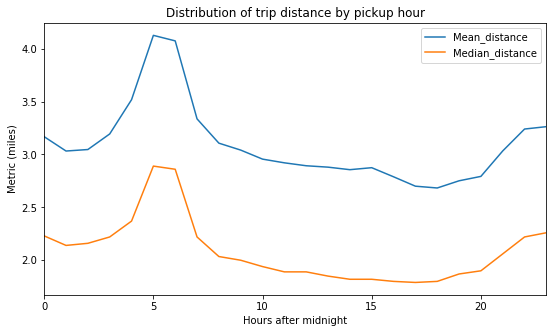

-----Trip distance by hour of the day-----

  Hour    Mean distance    Median distance
------  ---------------  -----------------
     0          3.1677               2.23
     1          3.0324               2.14
     2          3.0466               2.16
     3          3.19384              2.22
     4          3.5175               2.37
     5          4.12593              2.89
     6          4.07374              2.86
     7          3.33637              2.22
     8          3.10675              2.035
     9          3.04123              2
    10          2.95583              1.94
    11          2.92087              1.89
    12          2.89317              1.89
    13          2.87991              1.85
    14          2.85606              1.82
    15          2.87486              1.82
    16          2.78882              1.8
    17          2.70006              1.79
    18          2.68297              1.8
    19          2.75097              1.87
    20          2.79266           

In [213]:
# First, convert pickup and drop off datetime variable in their specific righ format
data['lpep_pickup_dt'] = data.lpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%m/%d/%y %H:%M"))
data['lpep_dropoff_dt'] = data.	Lpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%m/%d/%y %H:%M"))

# Second, create a variable for pickup hours
data['Pickup_hour'] = data.lpep_pickup_dt.apply(lambda x:x.hour)

# Mean and Median of trip distance by pickup hour
# I will generate the table but also generate a plot for a better visualization

fig,ax = plt.subplots(1,1,figsize=(9,5)) # prepare fig to plot mean and median values
# use a pivot table to aggregate Trip_distance by hour
table1 = data.pivot_table(index='Pickup_hour', values='Trip_distance',aggfunc=('mean','median')).reset_index()
# rename columns
table1.columns = ['Hour','Mean_distance','Median_distance']
table1[['Mean_distance','Median_distance']].plot(ax=ax)
plt.ylabel('Metric (miles)')
plt.xlabel('Hours after midnight')
plt.title('Distribution of trip distance by pickup hour')
#plt.xticks(np.arange(0,30,6)+0.35,range(0,30,6))
plt.xlim([0,23])
plt.savefig('Question3_1.jpeg',format='jpeg')
plt.show()
print ('-----Trip distance by hour of the day-----\n')
print (tabulate(table1.values.tolist(),["Hour","Mean distance","Median distance"]))

In [17]:
# Writing Key Notes take away. 

In [214]:
# Selecting airpor trips, finding the average of fare per trip, total amount charged. 
airports_trips = data[(data.RateCodeID== 1) | (data.RateCodeID == 3)]
print("Number of Trips to/ from NYC airports :" ,airports_trips.shape[0])
print("Average of Fare (calculated by meter) of trips to / from NYC airports: $ ",airports_trips.Fare_amount.mean(),"per trip")
print("Average Total Amount charged before the trips to / from NYC airports: $ ",airports_trips.Total_amount.mean(),"per trip")
print("Maximum of Fare (calculated by meter) of trips to / from NYC airports: $ ",airports_trips.Fare_amount.max(),"per trip")

Number of Trips to/ from NYC airports : 1020731
Average of Fare (calculated by meter) of trips to / from NYC airports: $  12.391516530799978 per trip
Average Total Amount charged before the trips to / from NYC airports: $  14.887327758421408 per trip
Maximum of Fare (calculated by meter) of trips to / from NYC airports: $  580.5 per trip


In [314]:
# data['lpep_pickup_datetime'].iloc[:-1:1].head()
data['lpep_pickup_datetime'].del(m/d/y)

SyntaxError: invalid syntax (<ipython-input-314-2b6faea81fff>, line 2)

Now that we have seen the number and mean fare of airport trips,
let's take a closer look at how trips are distributed by trip distances and hour of the day


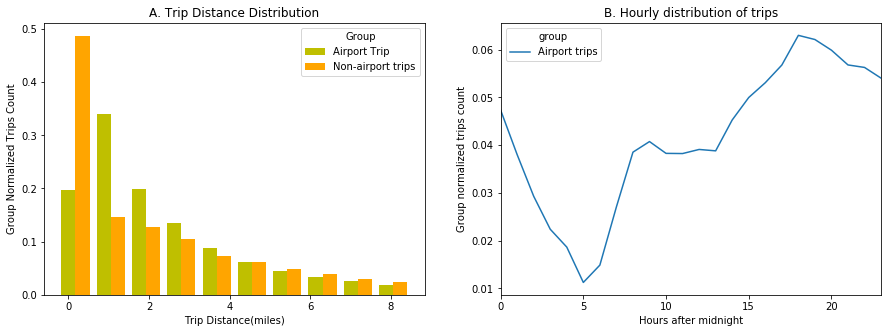

In [315]:
# Create a vector to contain Trip Distance . 
v1 = airports_trips.Trip_distance
v2 = data.loc[~data.index.isin (v1.index),'Trip_distance'] # non- airport trips

# remove outliers : 
# Exclude any data point located further than 2 standard deviations of the median point and histogram with 30 bins 

v1 = v1[~((v1-v1.mean()).abs()>2*v1.std())]
v2 = v2[~((v2-v2.mean ()).abs()>2*v2.std())]

# # Define Bins bounries.

bins = np.histogram(v1, normed = True)[1]
h1 = np.histogram(v1, bins = bins , normed = True)
h2 = np.histogram(v2 , bins = bins , normed =True)

# # plots distribution of trips distance normilized among groups 

fig,ax = plt.subplots(1,2,figsize = (15,5))
w =.4 *(bins[1] - bins[0])
ax[0].bar(bins[:-1], h1[0], alpha = 1 , width = w, color = 'y')
ax[0].bar(bins[:-1] + w, h2[0], alpha = 1 , width = w, color = 'orange')
ax[0].legend(['Airport Trip','Non-airport trips'] ,loc = 'best', title = 'Group')
ax[0].set_xlabel('Trip Distance(miles)')
ax[0].set_ylabel('Group Normalized Trips Count')
ax[0].set_title('A. Trip Distance Distribution')

airports_trips.Pickup_hour.value_counts(normalize=True).sort_index().plot(ax=ax[1])
# data.loc[~data.index.isin(v1.index),'Pickup_hour'].value_counts(normalize=True).sort_index().plot(ax=ax[1])
# data.loc[~data.index.isin(v1.index),'Pickup_hour'].value_counts(normalize=True).sort_index().plot(ax=ax[1])
ax[1].set_xlabel('Hours after midnight')
ax[1].set_ylabel('Group normalized trips count')
ax[1].set_title('B. Hourly distribution of trips')
ax[1].legend(['Airport trips','Non-airport trips'],loc='best',title='group')

plt.savefig('Question3_2.jpeg',format='jpeg')
plt.show()


#  Plot Hour Distribution  

A . The trip distance distribution shows two peaks . Airport trips follow 
the same trend as the rest of trips for short trips (trip distance less than or equal 2 miles).
However , there is also an increased number for long range trips (18 miles) which might 
correspond to a great number people coming to airports from further residential areas . 
A. check on a google map shows that the distance between JFK and Manhattan is about 18 miles whereas Newark to Manhattan is 15 miles . 

B. The hourly distribution shows that the number of trips at airports peaks around 3 Pm while it peaks 2 hours later .
on other hand , there is shortage in airports riders at 2 Am while the rest of NYC goes completely down 3 hours later at 5 AM . 

# Predictive Model 


In this section , I will take you through my analysis towards building a model to predict the percentage trip.

1. Let's build a derived variable for tips for a percentage of the total fare. 

Before we proceed with this , some cleaning are necessary . Since the initial charge for NYC green is $2.5 , 
any transaction with a small total amount is invalid , thus it to be dropped. 


In [317]:
data.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,9/1/15 0:02,9/1/15 0:02,N,5,-73.979485,40.684956,-73.979431,40.685020,1,...,7.8,0.0,0.0,1.95,0.0,NaN,0.0,9.75,1,2.0
1,2,9/1/15 0:04,9/1/15 0:04,N,5,-74.010796,40.912216,-74.010780,40.912212,1,...,45.0,0.0,0.0,0.00,0.0,NaN,0.0,45.00,1,2.0
2,2,9/1/15 0:01,9/1/15 0:04,N,1,-73.921410,40.766708,-73.914413,40.764687,1,...,4.0,0.5,0.5,0.50,0.0,NaN,0.3,5.80,1,1.0
3,2,9/1/15 0:02,9/1/15 0:06,N,1,-73.921387,40.766678,-73.931427,40.771584,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0
4,2,9/1/15 0:00,9/1/15 0:04,N,1,-73.955482,40.714046,-73.944412,40.714729,1,...,5.0,0.5,0.5,0.00,0.0,NaN,0.3,6.30,2,1.0


In [318]:
data = data[(data.Total_amount >= 2.5)] # Cleaning 
data["Tip_percentage"] = 100 * data.Total_amount / data.Total_amount 
print("Summary: Tip_percentage \n", data.Tip_percentage.describe())

Summary: Tip_percentage 
 count    1.043476e+06
mean     1.000000e+02
std      1.277300e-15
min      1.000000e+02
25%      1.000000e+02
50%      1.000000e+02
75%      1.000000e+02
max      1.000000e+02
Name: Tip_percentage, dtype: float64


2 . Similarly to the comparison between trips to /from airports with the rest of trips , it is worthy to spend more 
    time and check wether trips originating from Upper Manhattan have different percentage tip.
    
    To identify trips originating from upper Manhattan : 
        * From google map , collect latitude and longitude data of atleast 12 points that approximately define 
        the bounding box of upper Manhattan . 
        *Create a polygon using shapely.geometry.Polygon :[https://pypi.org/project/Shapely/]
        * Check if the polygon contain a location defined by (latitude, longitude)

            

In [319]:
# import library
from shapely.geometry import Point,Polygon,MultiPoint
# data points that define the bounding box of the Upper Manhattan
U_manhattan = [(40.796937, -73.949503),(40.787945, -73.955822),(40.782772, -73.943575),
              (40.794715, -73.929801),(40.811261, -73.934153),(40.835371, -73.934515),
              (40.868910, -73.911145),(40.872719, -73.910765),(40.878252, -73.926350),
              (40.850557, -73.947262),(40.836225, -73.949899),(40.806050, -73.971255)]
print(U_manhattan)


[(40.796937, -73.949503), (40.787945, -73.955822), (40.782772, -73.943575), (40.794715, -73.929801), (40.811261, -73.934153), (40.835371, -73.934515), (40.86891, -73.911145), (40.872719, -73.910765), (40.878252, -73.92635), (40.850557, -73.947262), (40.836225, -73.949899), (40.80605, -73.971255)]


In [320]:

poi = Polygon(umanhattan)
# poi
# # create a function to check if a location is located inside Upper Manhattan
def is_within_bbox(loc,poi=poi):
    """
    This function returns 1 if a location loc(lat,lon) is located inside a polygon of interest poi
    loc: tuple, (latitude, longitude)
    poi: shapely.geometry.Polygon, polygon of interest
    """
    return 1*(Point(loc).within(poi))
tic = dt.datetime.now()
print(tic)
# # Create a new variable to check if a trip originated in Upper Manhattan
data['U_manhattan'] = data[['Pickup_latitude','Pickup_longitude']].apply(lambda r:is_within_bbox((r[0],r[1])),axis=1)
print("Processing Time :", dt.datetime.now() - tic)

2020-01-01 22:41:51.338483
Processing Time : 0:00:48.774833


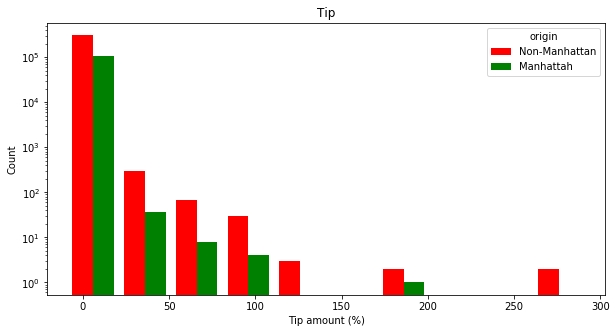

t-test results: Ttest_indResult(statistic=47.12962151545506, pvalue=0.0)


In [321]:
v1 = data[(data.U_manhattan== 0) & (data.Tip_amount>0)].Tip_amount
v2 = data[(data.U_manhattan==1) & (data.Tip_amount>0)].Tip_amount

# generate bins and histogram values
bins = np.histogram(v1,bins=10)[1]
h1 = np.histogram(v1,bins=bins)
h2 = np.histogram(v2,bins=bins)

# generate the plot
# First suplot: visualize all data with outliers
fig,ax = plt.subplots(1,1,figsize=(10,5))
w = .4*(bins[1]-bins[0])
ax.bar(bins[:-1],h1[0],width=w,color='r')
ax.bar(bins[:-1]+w,h2[0],width=w,color='g')
ax.set_yscale('log')
ax.set_xlabel('Tip amount (%)')
ax.set_ylabel('Count')
ax.set_title('Tip')
ax.legend(['Non-Manhattan','Manhattah'],title='origin')
plt.savefig('Origin_Tip.jpeg' , format ='jpeg')
plt.show()
print ('t-test results:', ttest_ind(v1,v2,equal_var=False))

Then two distribution look the same however the t-test results in zero p-value to imply tha the groups are different 
at 95 % level of comfidence 




# The Model
# Summary
The initial dataset contained 1048575 transactions with 21 time-series, categorical and numerical variables. In order to build the final model, four phases were followed (1) data cleaning, (2) feature engineering (3) exploratory data analysis and (4) model creation

The cleaning consisted in drop zero variance variables (Ehail_fee), replacing invalid with the most frequent values in each categorical variable whereas the median was used for continuous numerical variables. Invalid values could be missing values or values not allowed for specific variables as per the dictionary of variables. In this part, variables were also converted in their appropriate format such datetime.

The feature engineering part created 10 new variables derived from pickup and dropoff locations and timestamps, trip distance.

During the exploration, each variable was carefully analyzed and compared to other variables and eventually the target variable, Percentage tip. All numerical variables were found to follow lognormal or power law distributions althouth there was found no linear relationship between numerical and the target variable. An interesting insight was uncovered in the distribution of the percentage tip. It was found that only 40% of the transactions paid tip. And 99.99% of these payments were done by credit cards. This inspired me to build the predictive model in two stages (1) classification model to find out weither a transaction will pay tip and (2) regression model to find the percentage of the tip only if the transaction was classified as a tipper. Another insight was that the most frequent percentage is 18% which corresponds to the usual restaurant gratuity rate.

With lack of linear relationship between independent and depend variables, the predictive model was built on top of the random forest regression and gradient boosting classifier algorithms implemented in sklearn after routines to optimize best parameters. A usable script to make predictions as attached to this notebook and available in the same directory.

Note: The code to make predictions is provided in the same directory as tip_predictor.py and the instructions are in the recommendation part of this section.

# Data Cleaning 

In [223]:
# define a function to clean a loaded dataset

def clean_data(adata):
    """
    This function cleans the input dataframe adata:
    . drop Ehail_fee [99% transactions are NaNs]
    . compute  missing values in Trip_type
    . replace invalid data by most frequent value for RateCodeID and Extra
    . encode categorical to numeric
    . rename pickup and dropff time variables (for later use)
    
    input:
        adata: pandas.dataframe
    output: 
        pandas.dataframe

    """
    ## make a copy of the input
    data = adata.copy()
    ## drop Ehail_fee: 99% of its values are NaNs
    if 'Ehail_fee' in data.columns:
        data.drop('Ehail_fee',axis=1,inplace=True)

    ##  replace missing values in Trip_type with the most frequent value which is going to be 1
    data['Trip_type '] = data['Trip_type '].replace(np.NaN,1)
    
    ## replace all values that are not allowed as per the variable dictionary with the most frequent allowable value
    # remove negative values from Total amound and Fare_amount
    print ("Negative values found and replaced by their abs")
    print ("Total_amount", 100*data[data.Total_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("Fare_amount", 100*data[data.Fare_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("Improvement_surcharge", 100*data[data.improvement_surcharge<0].shape[0]/float(data.shape[0]),"%")
    print ("Tip_amount", 100*data[data.Tip_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("Tolls_amount", 100*data[data.Tolls_amount<0].shape[0]/float(data.shape[0]),"%")
    print ("MTA_tax", 100*data[data.MTA_tax<0].shape[0]/float(data.shape[0]),"%")
    
    data.Total_amount = data.Total_amount.abs()
    data.Fare_amount = data.Fare_amount.abs()
    data.improvement_surcharge = data.improvement_surcharge.abs()
    data.Tip_amount = data.Tip_amount.abs()
    data.Tolls_amount = data.Tolls_amount.abs()
    data.MTA_tax = data.MTA_tax.abs()
    
#     # RateCodeID
    indices_oi = data[~((data.RateCodeID>=1) & (data.RateCodeID<=6))].index
    data.loc[indices_oi, 'RateCodeID'] = 2 # 2 = Cash payment was identified as the common method
    print (round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in RateCodeID were invalid.--> Replaced by the most frequent 2")
    
#     # Extra
    indices_oi = data[~((data.Extra==0) | (data.Extra==0.5) | (data.Extra==1))].index
    data.loc[indices_oi, 'Extra'] = 0 # 0 was identified as the most frequent value
    print (round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in Extra were invalid.--> Replaced by the most frequent 0")
    
#     # Total_amount: the minimum charge is 2.5, so I will replace every thing less than 2.5 by the median 11.76 (pre-obtained in analysis)
    indices_oi = data[(data.Total_amount<2.5)].index
    data.loc[indices_oi,'Total_amount'] = 11.76
    print (round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in total amount worth <$2.5.--> Replaced by the median 1.76")
    
    # encode categorical to numeric (I avoid to use dummy to keep dataset small)
    if data.Store_and_fwd_flag.dtype.name != 'int64':
        data['Store_and_fwd_flag'] = (data.Store_and_fwd_flag=='Y')*1
    
    # rename time stamp variables and convert them to the right format
    print ("renaming variables...")
    data.rename(columns={'lpep_pickup_datetime':'Pickup_dt','Lpep_dropoff_datetime':'Dropoff_dt'},inplace=True)
    
    # Converting time stamp to the right format . 
    print("converting timestamps variables to right format ...")
    
    data['Pickup_dt'] = data.Pickup_dt.apply(lambda x :dt.datetime.strptime(x, "%m/%d/%y  %H:%M"))
    data['Dropoff_dt'] = data.Dropoff_dt.apply(lambda x :dt.datetime.strptime(x, "%m/%d/%y  %H:%M"))
    
    print ("Done cleaning")
    
    return data


In [323]:
# Run code to clean the data
data = clean_data(data)

Negative values found and replaced by their abs
Total_amount 0.0 %
Fare_amount 0.0 %
Improvement_surcharge 0.0 %
Tip_amount 0.0 %
Tolls_amount 0.0 %
MTA_tax 0.0 %
0.0 % of values in RateCodeID were invalid.--> Replaced by the most frequent 2
0.0 % of values in Extra were invalid.--> Replaced by the most frequent 0
0.0 % of values in total amount worth <$2.5.--> Replaced by the median 1.76
renaming variables...
converting timestamps variables to right format ...
Done cleaning


# Feature Engineering 

In this step, I intuitively created new varibles derived from current variables.

*Time variables: Week, Month_day(Day of month), Week_day (Day of week), Hour (hour of day), Shift_type (shift period of the day) and Trip_duration.The were created under the hypothesis that people may be willing to tip depending on the week days or time of the day. For instance, people are more friendly and less stressful to easily tip over the weekend. They were derived from pickup time
*.Trip directions: Direction_NS (is the cab moving Northt to South?) and Direction_EW (is the cab moving East to West). These are components of the two main directions, horizontal and vertical. The hypothesis is that the traffic may be different in different directions and it may affect the riders enthousiasm to tipping. They were derived from pickup and dropoff coordinates
*.Speed: this the ratio of Trip_distance to Trip_duration. At this level, all entries with speeds higher than 240 mph were dropped since this is the typical highest speed for cars commonly used as taxi in addition to the fact that the speed limit in NYC is 50 mph. An alternative filter threshold would be the highest posted speed limit in NYC but it might be sometimes violated.
*.With_tip: This is to identify transactions with tips or not. This variable was created after discovering that 60% of transactions have 0 tip.
*****.As seen that using the mean of trips from Manhattan is different from the mean from other boroughs, this variable can be considered as well in the model building. A further and deep analysis, would be to create a variable of the origin and destination of each trip. This was tried but it was computationally excessive to my system. Here, coming from Manhattan or not, is the only variable to be used.

In [324]:

# Function to run the feature engineering
def engineer_features(data):
    """
    This function create new variables based on present variables in the dataset adata. It creates:
    . Week: int {1,2,3,4,5}, Week a transaction was done
    . Week_day: int [0-6], day of the week a transaction was done
    . Month_day: int [0-30], day of the month a transaction was done
    . Hour: int [0-23], hour the day a transaction was done
    . Shift type: int {1=(7am to 3pm), 2=(3pm to 11pm) and 3=(11pm to 7am)}, shift of the day  
    . Speed_mph: float, speed of the trip
    . Tip_percentage: float, target variable
    . With_tip: int {0,1}, 1 = transaction with tip, 0 transction without tip
    
    input:
        adata: pandas.dataframe
    output: 
        pandas.dataframe
    """
    
    # make copy of the original dataset
    data = data.copy()
    
    # derive time variables
    print("deriving time variables...")
#     reference week "First week of Septemeber in 2015" 
# date(2003, 12, 29).isocalendar()
 
    ref_week = dt.datetime(2015,9,1).isocalendar()[1]
  
    data['Week'] = data.Pickup_dt.apply(lambda x:x.isocalendar()[1]- ref_week + 1 )
    data['Week_day'] = data.Pickup_dt.apply(lambda x:isocalendar()[2])
    data['Month_day'] = data.Pickup_dt.apply(lambda x:x.day)
    data.rename(columns ={'Pick_hour':'Hour'} , inplace =True)
    data['Hour'] = data.Pickup_dt.apply(lambda x:x.hour)
    
#  Create shift variable: 1= (7am to 3 pm) , 2 =(3pm to 11 pm) , 3 = (11 pm to 7 am )
   
    data['Shift_type']=np.NAN
    data.loc[data[(data.Hour >=7) & (data.Hour<15)].index,'Shift_type'] = 1
    data.loc[data[(data.Hour >=15) & (data.Hour<23)].index,'Shift_type'] = 2
    data.loc[data[data.Shift_type.isnull()].index,'Shift_type'] = 3
    
#     Trip Duration 
    print("Deriving Trip_duration ....")
    data['Trip_duration'] = ((data.Dropoff_dt - data.Pickup_dt).apply(lambda x:x.total_seconds()/60.))
                  
    print("Deriving direction variables...")
#     Create direction variables Direction_North_South (NS)
#     This is 2 if Taxi moving frm North to South , 1 in the opposite direction and = 0 otherwise. 
    data['Direction_NS'] = (data.Pickup_latitude > data.Dropoff_latitude)* 1+1 
    indices = data[(data.Pickup_latitude == data.Dropoff_latitude) & (data.Pickup_latitude !=0)].index
    data.loc[indeces, 'Direction_NS'] = 0
# Create direction variables of Direction_EW(East to West) 
    data["Direction_EW"] = (data.Pickup_longitude > data.Dropoff_longitude) * 1+1
    indeces = data[(data.Pickup_longitude ==data.Dropoff_longitude) & (data.Pickup_longitude !=0)].index
    data.loc[indeces,'Direction_EW'] = 0 
# Create a variable for speed 
    print("deriving Speed. make sure to check for possible NANS and inf vals...")
    data['Speed_mph'] = data.Trip_distance / (data.Trip_duration / 60)
#      replace all NANs values and values > 240mph by values samples from a random distribution of mean 12.9  and standard deviation 
#      6.8 mph. These Values were extracted from the distribution 
    indeces_oi = data[(data.Speed_mph.isnull()) / (data.Speed_mph>240)].index
    data.loc[indeces_oi, 'Speed_mph'] = np.abs(np.random.normal(loc=12.9, scale =6.8, size= len(indices_oi)))
    print("Greate we are done with Feature Engineering ! :-")
#      Create a new a variable to check if the trip originated in Upper Manhattan 
    print("Checking where the trip originated")
    data[U_manhattan] = data[['Pickup_latitude','Pickup_longitude']]. apply(lambda r: is_within_bbox((r[0], r[1])), axis=1)
#     create a tip percentage variable
    data['Tip_percentage'] = 100*data.Tip_amount / data.Total_amount
#     Create with tip variable 
    data['With_tip'] =(data.Tip_percentage > 0)*1 
    
    return data

# collected bounding box points
umanhattan = [(40.796937, -73.949503),(40.787945, -73.955822),(40.782772, -73.943575),
              (40.794715, -73.929801),(40.811261, -73.934153),(40.835371, -73.934515),
              (40.868910, -73.911145),(40.872719, -73.910765),(40.878252, -73.926350),
              (40.850557, -73.947262),(40.836225, -73.949899),(40.806050, -73.971255)]

poi = Polygon(umanhattan)
# create a function to check if a location is located inside Upper Manhattan
def is_within_bbox(loc,poi=poi):
    """
    This function checks if a location loc with lat and lon is located within the polygon of interest
    input:
    loc: tuple, (latitude, longitude)
    poi: shapely.geometry.Polygon, polygon of interest
#     """
    return 1*(Point(loc).within(poi))

In [325]:
#  return the code to create a new features on the dataset
#  There is a bug here that I am trying to fix . error message : Isocalendar not defined .
#  Excepected  the size to change after feature engineering 
print("Size before feature engineering:", data.shape)
# data = engineer_features(data)
print("Size after feature engineering:",data.shape)

Size before feature engineering: (1043476, 22)
Size after feature engineering: (1043476, 22)


In [326]:
#  Uncomment to check for data validity. 
data.describe().T


,count,mean,std,min,25%,50%,75%,max
VendorID,1043476.0,1.784992,4.108283e-01,1.000000,2.000000,2.000000,2.000000,2.000000
Store_and_fwd_flag,1043476.0,0.006059,7.760087e-02,0.000000,0.000000,0.000000,0.000000,1.000000
RateCodeID,1043476.0,1.087320,5.730223e-01,1.000000,1.000000,1.000000,1.000000,6.000000
Pickup_longitude,1043476.0,-73.840978,2.635304e+00,-83.277878,-73.959480,-73.945305,-73.917244,0.000000
Pickup_latitude,1043476.0,40.696323,1.453329e+00,0.000000,40.698101,40.746593,40.802101,43.177261
Dropoff_longitude,1043476.0,-73.854521,2.429046e+00,-83.277832,-73.967941,-73.945053,-73.910156,0.000000
Dropoff_latitude,1043476.0,40.701976,1.339621e+00,0.000000,40.698414,40.746975,40.789391,42.799343
Passenger_count,1043476.0,1.375598,1.044755e+00,0.000000,1.000000,1.000000,1.000000,9.000000
Trip_distance,1043476.0,3.001668,3.053985e+00,0.000000,1.100000,2.000000,3.800000,246.280000
Fare_amount,1043476.0,12.738312,1.006470e+01,0.000000,6.500000,10.000000,15.500000,580.500000


# Exploratory Data Analysis 

This was the key phase of the analysis . A look at the distribution of the target
variable , Tip_percentage showed that 60 % of all transaction did not give tip(See Figure below , left).
A second tip at 18 % corresponds to the usual NYC customary 
gratuity rate which fluctuates between 18 % and 25 % (See Figure below , right).
Based on the information , the model ca be bult in two steps . 

* First Step: Create classification model to predict wether tip will be given or not . Here a new variable " with_tip" of 1 (if there is tip ) and 0 (otherwise) was created. 
* Second Create regression model for transaction with non-zero tip. 


The two distributions look the same however the t-test results in a zero p-value to imply that the two groups are  different at  92% level of condidence

In [327]:
data = data[(data.Total_amount >= 2.5)] # Cleaning 
data["Tip_percentage"] = 100 * data.Fare_amount / data.Total_amount 
print("Summary: Tip_percentage \n", data.Tip_percentage.describe())

Summary: Tip_percentage 
 count    1.043476e+06
mean     8.272139e+01
std      9.814755e+00
min      0.000000e+00
25%      7.583682e+01
50%      8.333333e+01
75%      9.057971e+01
max      1.000000e+02
Name: Tip_percentage, dtype: float64


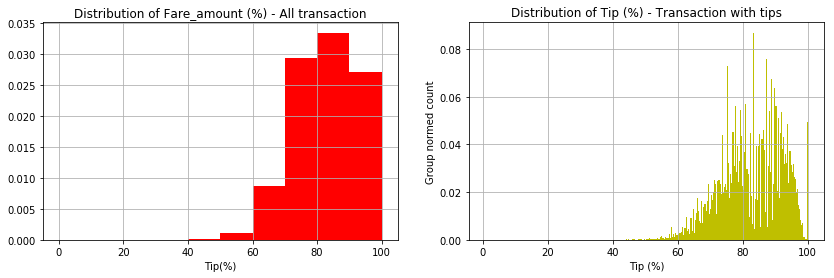

In [328]:
# Code to compare the two tips_percentage indentifed groups 
## code to compare the two Tip_percentage identified groups
# split data in the two groups

data1= data [data.Tip_percentage > 0]  
data2 = data[data.Tip_percentage == 0 ]

# # generate histograms to compare

fig,ax = plt.subplots(1,2,figsize =(14,4))
data.Tip_percentage.hist(bins =10,normed=True, ax=ax[0] , color ='r')
ax[0].set_xlabel('Tip(%)')
ax[0].set_title('Distribution of Fare_amount (%) - All transaction')
data1.Tip_percentage.hist(bins =300,normed=True,ax=ax[1], color ='y')
ax[1].set_xlabel('Tip (%)')
ax[1].set_title('Distribution of Tip (%) - Transaction with tips')
ax[1].set_ylabel('Group normed count')

plt.savefig('Question4_target_varc.jpeg',format='jpeg')

plt.show()


In [230]:
# Functions For Exploratory Data Analysis 
def visualize_contious(df, label, method={'type':'histogram','bins':20},outlier ='on'):
    """
    The function to quickly visualize continuos variables 
    df:pandas.dataFrame
    label:str, name of variable to be plotted . it should be present in df.columns
    method:dict, contains info of the type of plot to generate . It can be histogram or boxplot 
    [-Not yet developped]
    outlier:{'on','off'}, set it off you need to cut off outliers .
    Outliers are all those points 
    Located at 3 standard deviations further from the mean.
    
    """
#     Create Vector of variable of interest 
    v = df[label]
#     Define     mean and standard deviation
    m = v.mean()
    s = v.std()
    fig, ax = plt.subplots (1, 2, figsize=(14,4))
    ax[0].set_title('Distribution of' + label)
    ax[1].set_title('Tip % by '+ label)
    if outlier == 'off':   # remove outliers accondingly and update titles 
        v = v[(v-m) < 3 * s]
        ax[0].set_title('Distribution of' + label + '(no outliers)')
        ax[1].set_title('Tip % by' + label+'(no outliers)')
    if method['type'] == 'histogram': # plot the histogram
        v.hist(bins =method['bins'], ax=ax[0])
    if method['type'] == 'boxplot' : # plot the box plot 
        df.loc[v.index].boxplot(label, ax =ax[0])
    ax[1].plot(v,df.loc[v.index].Tip_percentage,'.',alpha = 0.4)
    ax[0].set_xlabel(label)
    ax[1].set_xlabel(label)
    ax[0].set_ylabel('Count')
    ax[1].set_ylabel('Tip (%)') 
    
def visualize_categories(df, CatName ,chart_type = 'Histogram',ylimit =[None,None]):
    
    """
    This Functions Helps to quickly visualize categorical variables . 
    this functions calls other functions generate_boxplot and generate_histogram 
    df:pandas.DataFrame 
    chart_type : {histogram, boxplot}, choose which type of chart to plot 
    ylim:tuple, list.Valid if chart_type is histogram 
    """
    
    print(catName) 
    cats= sorted(pd.unique(df[catName]))
    if chart_type == 'boxplot': # generate boxplot 
        generate_boxplot(df, catName , ylimit)
    elif chart_type == 'histogram': # generate histogram
        generate_histogram(df, catName)
    else: 
        pass 
    # calculate test Stastics 
    groups = df[[catName ,'Tip_percentage']].groupby(catName).groups # create groups
    tips = df.Tip_percentage
    if len(cats) <= 'catName': # if there are only two groups use t-test
        print(ttest_ind(tips[groups[cats[0]]], tips[groups[cats[1]]]))
    else: # otherwise the command to be evaluated 
        cmd = "f_oneway("
        for cat in cats :
            cmd +="tips[groups["+str(cat)+"]],"
            cmd = cmd[:-1]+")"
            print("one way anova test:" , eval(cmd)) # Evaluate the command and print 
        print("frequency of categories (%):\n", df[catName].value_counts(normalize = True)*100)
        
def test_classification(df, label, y1=[0,50]):
    """
    This Function test if the means of the two groups with_tip and without tip are different 
    at 95 % of confidence level. 
    It will also generate a box plot of the viariable by tipping groups
    label:str ,label to test 
    y1:tuple or list (default = [0,50]) , y limits on the ylabel of the boxplot 
    df:pandas.DataFrame(deafult =data)
    
    Example:run <visualize_continous(data,'Fare_amount', outlier ='on ') >
    
    """
    
    if len(pd.unique(df[label])) == 2: # check if the variable is categorical with only two
# categories  and run the test .
        vals = pd.unique(df[label])
        gp1 =df[df.With_tip == 0][label].value_counts().sort_index()
        gp2 =df[df.With_tip == 1][label].value_counts().sort_index()
        print("t-test if ", label , "can be used to distinguish transanctionwith tip and without tip")
        print("chisquare(gp1,gp2)")
    elif len(pd.unique(df[label])) >= 10 : # otherwise run the t-test
        df.boxplot(label, by='With_tip')
        plt.ylim(y)
        plt.show 
#         print("t-test if, label , can be used to distinguish transaction with tip and without  " )
        print("results:", ttest_ind(df[df.WIth_tip == 0][label].value, df[df.With_tip ==1][label].values , False))
    else:         
         passs 
        
def generate_boxplot(df,catName,ylimit):
    """
    generate boxplot of tip percentage by variable "catName" with ylim set ylimit 
    df:pandas.Dataframe
    catName :str
    ylimit :tuple , list 
    """
    df.boxplot('Tip_percentage', by=CatName)
    # plt.title('Tip % by ' +catName )
    plt.title('')
    plt.ylabel('Tip (%)')
    if ylimit != [None, None]:
        plt.ylim(ylimit)
    plt.show()
    
def generate_histogram(df, catName):
    
    """
    generate histogram of tip percentage by varible "CatName" with ylimit set ylimit
    df: pandas.dataFrame 
    catName : str 
    ylimit : tuple , list 
    
    """
    
    cats = sorted(pd.unique(df[catName]))
    colors =plt,cm.jet(np.linspace(0,1,len(cats)))
    hx = np.array(map(lambda x : round(x, 1 ), np.histogram(df.Tip_percentage,bins=20)[1]))
    fig , ax = plt.subplots(1,1,figsize=(15, 4))
    for i , cat in enumerate (cats):
        vals =df [df[catName] == cat ].Tip_percentage
        h=np.histogram(vals, bins =hx)
        w =0.9*(hx [:-1]+ w*i, h[0], colors == colors[i], width == w)
    plt.legend(cats)
    plt.ysccale('log')
    plt.title ('Distribution of Tip by' + catName )
    plt.xlabel ('Tip (%)')
    
#     plt.show()
    

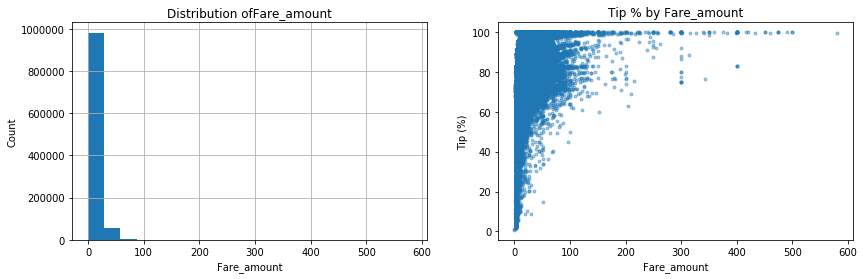

In [330]:
# Example of exploration of the Fare_amount using the implemented:
visualize_contious(data1 , 'Fare_amount', outlier ='on')
plt.savefig('DistribFAmount.png', format ='png')